In [16]:
import pandas as pd
from io import StringIO
from xlsx2csv import Xlsx2csv
from typing import List
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
from scipy.optimize import curve_fit
from datetime import datetime
from session import ProductionSession, Session
from functions import (get_futures_historical_data,
                       get_historical_forward_curves, get_quotes)
from dxfeed_clee.futures import cme_contract_code_to_datetime

import asyncio
import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def read_excel_fast(
    path: str,
    sheet_name="Sheet1",
    cols_to_read: List[str] = None,
    chunk_size: int = None,
    parse_dates: List[str] = None,
    index=False,
) -> pd.DataFrame:
    buffer = StringIO()
    Xlsx2csv(path, outputencoding="utf-8", sheetname=sheet_name).convert(buffer)
    buffer.seek(0)
    
    if cols_to_read is not None:
        usecols_options = lambda x: x in cols_to_read
    else:
        usecols_options = None

    if chunk_size:
        chunks = []
        for chunk in pd.read_csv(buffer, usecols=usecols_options, chunksize=chunk_size):
            chunks.append(chunk)
        df_read = pd.concat(chunks, ignore_index=True)
    else:
        if index:
            df_read = pd.read_csv(buffer, usecols=usecols_options, index_col=0)
        else:
            df_read = pd.read_csv(buffer, usecols=usecols_options)
    
    if parse_dates:
        for date_cols in parse_dates:
            df_read[date_cols] = pd.to_datetime(df_read[date_cols])
    
    return df_read

In [8]:
symbol = "NG"
df_fwd_curve = read_excel_fast(f"historical_{symbol}_futures_curve.xlsx", index=True)
df_fwd_curve.index = pd.to_datetime(df_fwd_curve.index)
df_fwd_curve

,/NGG20,/NGH20,/NGJ20,/NGK20,/NGM20,/NGN20,/NGQ20,/NGU20,/NGV20,/NGX20,...,/NGH29,/NGJ29,/NGK29,/NGM29,/NGN29,/NGQ29,/NGU29,/NGV29,/NGX29,/NGZ29
2020-01-01 12:00:00,2.130,2.101,2.103,2.143,2.200,2.262,2.283,2.277,2.307,2.397,...,2.330,2.330,2.330,2.330,2.330,2.330,2.330,2.330,2.330,2.330
2020-01-02 12:00:00,2.120,2.104,2.105,2.143,2.202,2.262,2.278,2.273,2.313,2.398,...,2.650,2.650,2.650,2.650,2.650,2.650,2.650,2.650,2.650,2.650
2020-01-05 12:00:00,2.150,2.144,2.144,2.184,2.243,2.301,2.317,2.309,2.343,2.425,...,2.280,2.280,2.280,2.280,2.280,2.280,2.280,2.280,2.280,2.280
2020-01-06 12:00:00,2.153,2.146,2.140,2.177,2.232,2.286,2.303,2.296,2.331,2.416,...,2.330,2.330,2.330,2.330,2.330,2.330,2.330,2.330,2.330,2.330
2020-01-07 12:00:00,2.151,2.141,2.141,2.179,2.237,2.296,2.311,2.302,2.333,2.414,...,2.561,2.561,2.561,2.561,2.561,2.561,2.561,2.561,2.561,2.561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-07 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.952,3.952,3.952,3.952,3.952,3.952,3.952,3.952,3.952,3.952
2024-04-08 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.705,4.705,4.705,4.705,4.705,4.705,4.705,4.705,4.705,4.705
2024-04-09 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.503,4.503,4.503,4.503,4.503,4.503,4.503,4.503,4.503,4.503
2024-04-10 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.400,3.400,3.400,3.400,3.400,3.400,3.400,3.400,3.400,3.400


In [9]:
spot_dates = {
    c: cme_contract_code_to_datetime(c) for c in list(df_fwd_curve.columns)
}
df_front = yf.Ticker(f"{symbol}=F").history(
    start=min(spot_dates.values()), end=max(spot_dates.values())
)
df_front.index = df_front.index.tz_localize(None)
display(df_front)

spot_cl_to_plot = {} 
for c, d in spot_dates.items():
    if d > datetime.today():
        break
    try:
        close_value = df_front.loc[d, 'Close']
    except KeyError:
        nearest_date = df_front.index.get_loc(d, method='nearest')
        close_value = df_front.iloc[nearest_date]['Close']
    
    spot_cl_to_plot[c] = close_value

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-02-03,1.852,1.880,1.814,1.819,163786,0.0,0.0
2020-02-04,1.823,1.888,1.804,1.872,184043,0.0,0.0
2020-02-05,1.876,1.884,1.825,1.861,195459,0.0,0.0
2020-02-06,1.865,1.906,1.832,1.862,186209,0.0,0.0
2020-02-07,1.863,1.898,1.842,1.858,272131,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-08,1.770,1.850,1.746,1.844,216676,0.0,0.0
2024-04-09,1.847,1.924,1.838,1.872,215016,0.0,0.0
2024-04-10,1.888,1.943,1.867,1.885,174388,0.0,0.0


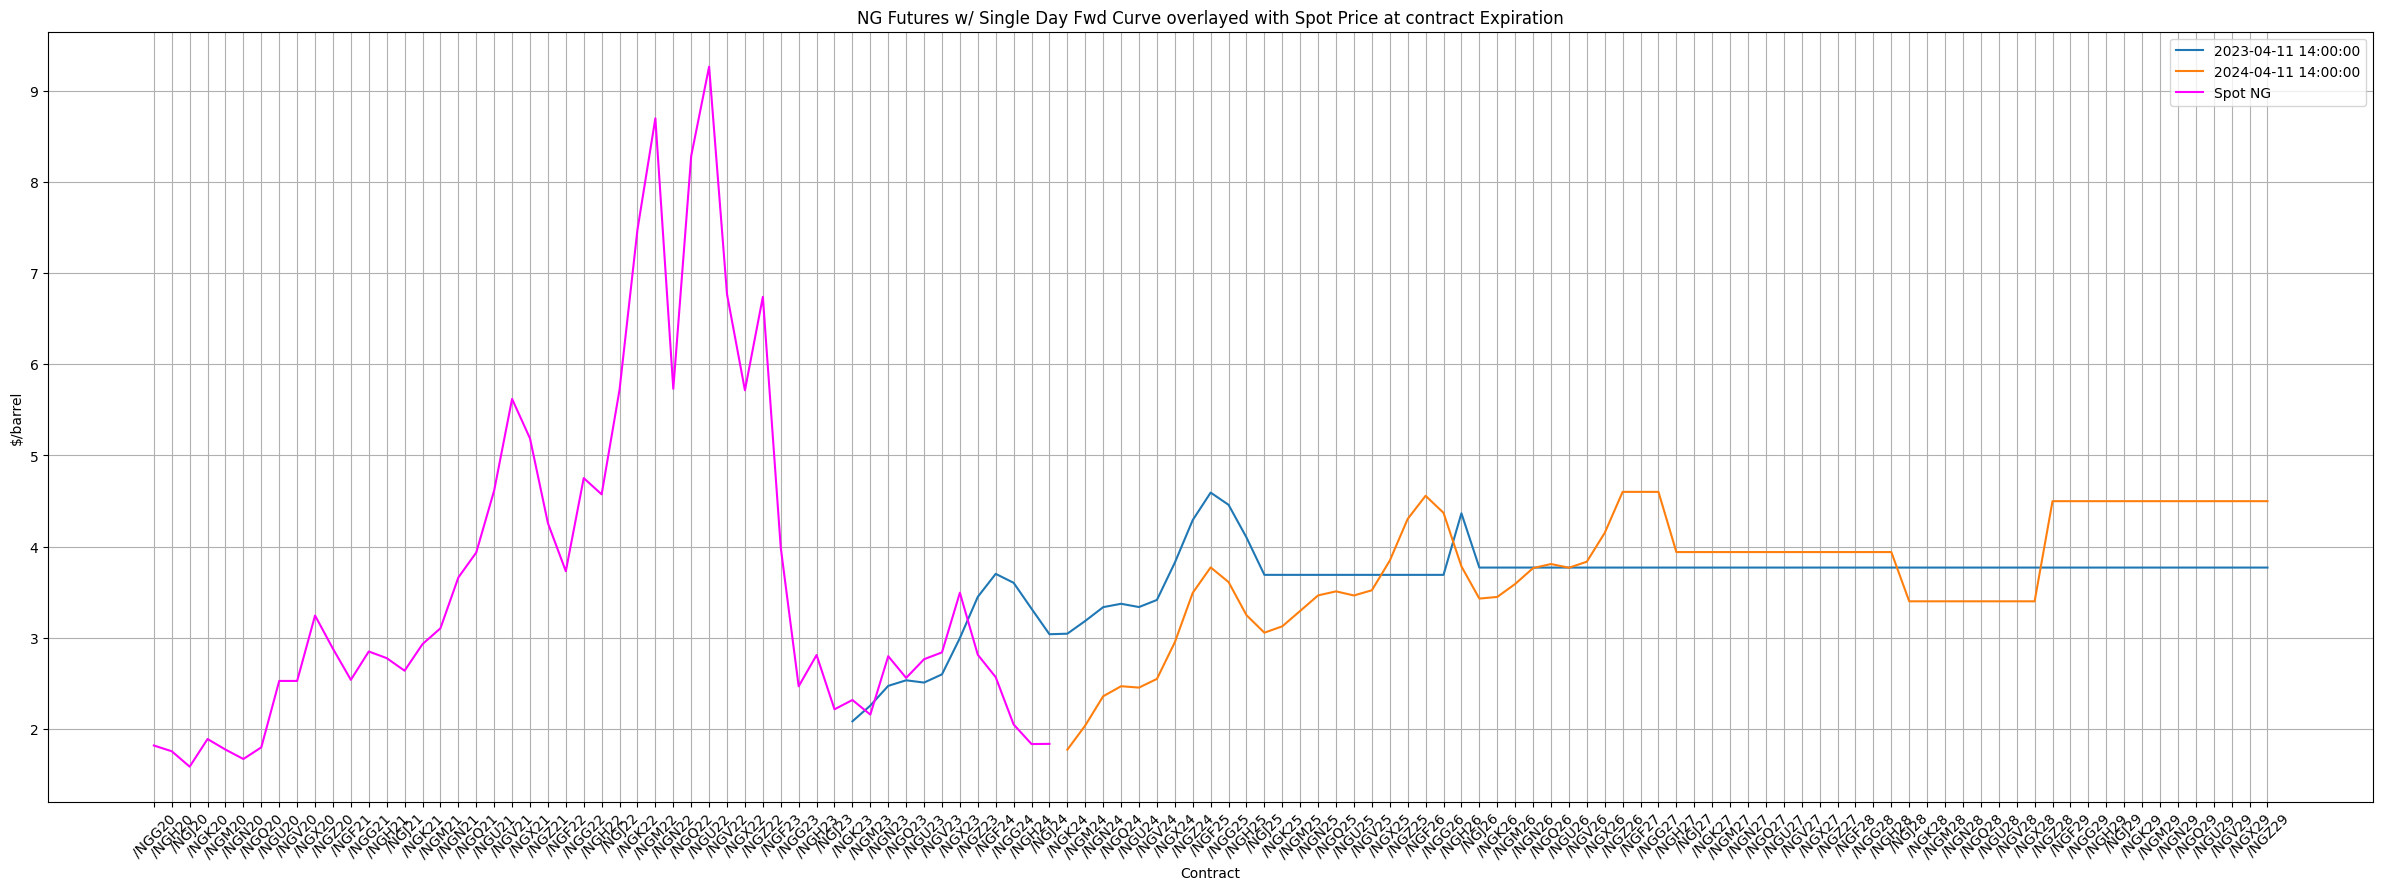

In [35]:
plt.figure(figsize=(30, 10))

# df = df_fwd_curve.resample('Q').last()
df = df_fwd_curve[
    (df_fwd_curve.index.year == 2024)
    & (df_fwd_curve.index.month == 4)
    & (df_fwd_curve.index.day == 11)
    
    # | (df_fwd_curve.index.year == 2024)
    # & (df_fwd_curve.index.month == 1)
    # & (df_fwd_curve.index.day == 3)
    
    | (df_fwd_curve.index.year == 2023)
    & (df_fwd_curve.index.month == 4)
    & (df_fwd_curve.index.day == 11)
]
# df = df.resample("Q").last()

for index, row in df.iterrows():
    plt.plot(row.index, row.values, label=f"{index}")

dict_series = pd.Series(spot_cl_to_plot)
plt.plot(
    dict_series.index,
    dict_series.values,
    label=f"Spot {symbol}",
    linestyle="-",
    linewidth=1.5,
    color="magenta",
)

plt.xlabel("Contract")
plt.ylabel("$/barrel")
plt.title(
    f"{symbol} Futures w/ Single Day Fwd Curve overlayed with Spot Price at contract Expiration"
)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

In [25]:
def plot_fwd_curve(
    df_future_quotes: pd.DataFrame, title: str = None, units: str = None
):
    plt.figure(figsize=(17, 6))
    plt.plot(
        df_future_quotes["Contract"],
        df_future_quotes["Price"],
        marker="o",
        linestyle="-",
        color="blue",
    )
    contract = str(df_future_quotes.iloc[0]["Contract"]).split(":")[0][:-3]
    plt.title(title or f"{contract} Forward Curve")
    plt.xlabel("Date")
    plt.ylabel("Price" if not units else "Price " + units)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

In [26]:
df_secret = pd.read_csv(r"C:\Users\chris\trade\curr_pos\secret.txt")
my_email = df_secret.iloc[0]["email"]
my_username = df_secret.iloc[0]["username"]
my_password = df_secret.iloc[0]["password"]
session = ProductionSession(my_username, my_password, remember_token=True)

In [27]:
quotes = asyncio.run(get_quotes(session=session, contract_code="NG", just_midpoint=True, return_df=True))
quotes

,Contract,Price
0,/NGK24:XNYM,1.7725
1,/NGM24:XNYM,2.04
2,/NGN24:XNYM,2.3785
4,/NGQ24:XNYM,2.47
5,/NGU24:XNYM,2.4365
6,/NGV24:XNYM,2.5575
7,/NGX24:XNYM,2.9315
8,/NGZ24:XNYM,3.5225
9,/NGF25:XNYM,3.7195
10,/NGG25:XNYM,3.7215


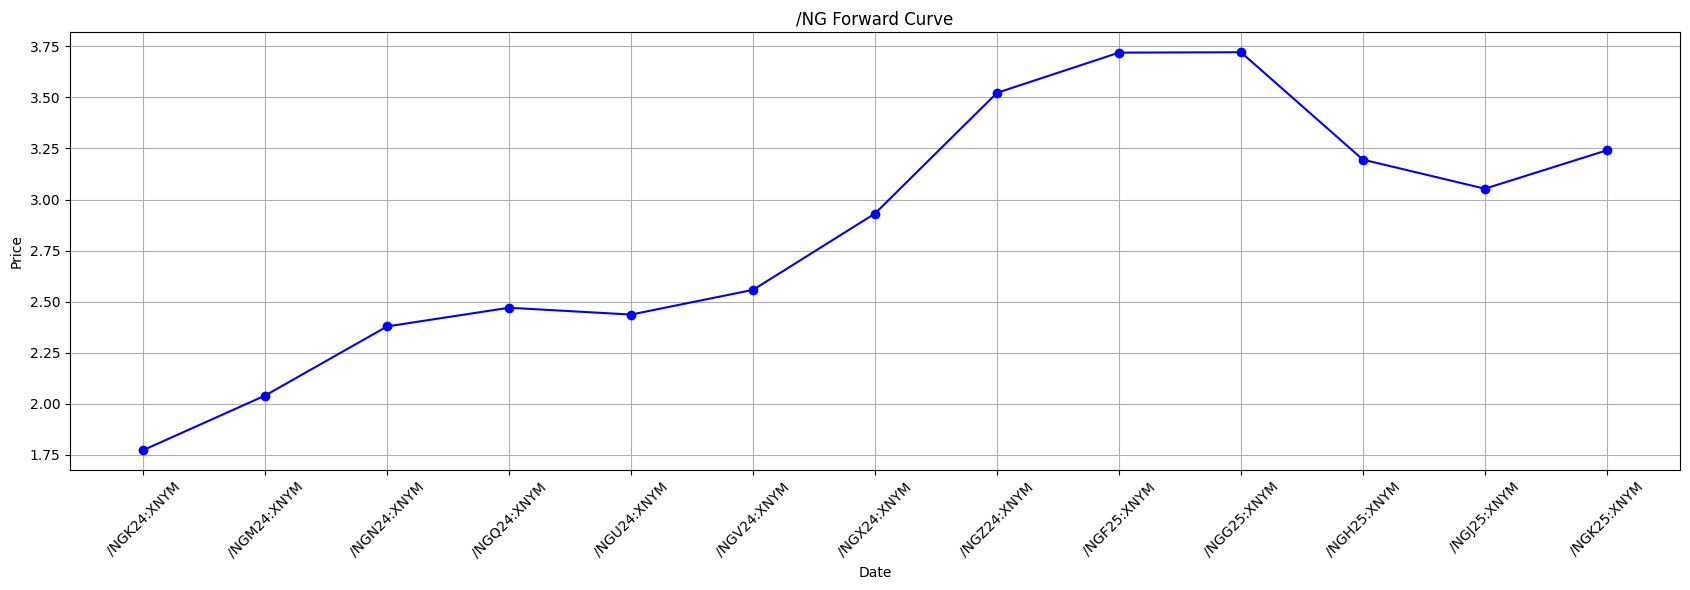

In [28]:
plot_fwd_curve(quotes)